# Project: Vehicle Detection and Tracking
The goal of this project is to implement a pipeline to detect cars at a video stream and track them.

**Credits**: Some functions used in this project were provided by Udacity at the related lesson from the SDC ND. Many of them were tunned and updated to fit the pipeline process.

## Pipeline helper - Feature extraction
The section below presents the functions related to feature extraction from the input image. These features are fed to the previously generated model in order to predict if the current window contains or not a vehicle.

In [1]:
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
# Helper function for feature extraction - Perform color conversion 
# Color Space YCrCb was used for training and prediction
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Helper function for feature extraction - Extracts the HOG from the input image
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Helper function for feature extraction - Computes image input resize
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Helper function for feature extraction - Computes the color Histogram from image input
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## Pipeline helper - Draw and Visualization
The following section presents some helper functions used on drawing windows for vehicle detection and other the auxiliate the pipeline process visualization.

In [3]:
def pltSingle(img, title, plot=True, axis_grid='off'):
    if plot == True:
        f, ax = plt.subplots(1,1)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis(axis_grid)
        plt.show()

In [4]:
def pltCompare(img1, title1, img2, title2, plot=True, axis_grid='off'):
    if plot == True:
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
        ax1.imshow(img1)
        ax1.set_title(title1)
        ax1.axis(axis_grid)
        ax2.imshow(img2)
        ax2.set_title(title2)
        ax2.axis(axis_grid)
        plt.show()

In [5]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes

## Pipeline helper - Car Detection and Tracking
The following function **find_cars()** was adapted and enhanced based on sample code provided by Udacity. This funcion:
- Extracts features from a given image region to be fed to the the Model for prediction. Namely Spacial features, Color features (after some experimentation, the inicial RGB channel was updated to YCrCb) and HOG features based on the three image channels. 
- Use HOG sub-sampling for feature extraction
>NOTE: Sub-sampling for performance instead of computing HOG for each window analysis
- Use a sliding windows technique to input images to the trained model and predict if the current window contains or not a car
- Returns the windows coordinates for sampling windows where the the model detected a car.

In [6]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, step, spatial_size, hist_bins):
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    bboxes = []
    
    img_tosearch = img[ystart:ystop, xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = step  # Instead of overlap, define how many cells to step
    # Tunning
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                
    return bboxes

## Pipeline helper - Heatmap
This section presents the helper functions used to extract a so called Heatmap. The heatmap has as role identify and eliminate false positives and also provide a "Momentum" to the vehicle detection on the next frame. This is achieved via the global decke variable "heatmaps".

In [7]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bboxa
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bbox_heat = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_heat.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, bbox_heat

## Pipeline - Parameters
The following section presents the parameter extraction for the pipeline. In specific, it syncs the feature configuration used at the Model training to the pipeline.  

In [8]:
svc_params_dict = pickle.load( open("20-output-classifier.p", "rb" ) )
svc = svc_params_dict["svc"]
X_scaler = svc_params_dict["scaler"]
orient = svc_params_dict["orient"]
pix_per_cell = svc_params_dict["pix_per_cell"]
cell_per_block = svc_params_dict["cell_per_block"]
spatial_size = svc_params_dict["spatial_size"]
hist_bins = svc_params_dict["hist_bins"]

In [9]:
import collections
heatmaps = collections.deque(maxlen=20)

# Workaround for not using classes
def init_pipeline(heatmaps_len=20):
    global heatmaps
    heatmaps = collections.deque(maxlen=heatmaps_len)

## Pipeline - Main
As indicated, this section presents the core from the Vehicle Detection and Tracking pipeline. 

This pipeline uses different sliding window sizes, associated with different regions of interest and steps. This helps on speed processing limiting the number of windows searching for vehicles. After gathering all windows with a vehicle prediction a heatmap is stored in order to present one single Vehicle identified box.

In [10]:
def pipeline(img, plot=False):
    global svc
    global X_scaler
    global orient
    global pix_per_cell
    global cell_per_block
    global spatial_size
    global hist_bins
    global heatmaps

    pltSingle(img, 'Input Pipeline: Input image', plot)
    
    # Placeholder for each window which the model predicts a vehicle
    box_list = []
    
    # Each window size has specific regions of interest
    bb = find_cars(img, 400, 540, 700, 1100, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, 2, spatial_size, hist_bins)
    box_list = box_list + bb
    bb = find_cars(img, 400, 550, 700, 1280, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, 1, spatial_size, hist_bins)
    box_list = box_list + bb
    bb = find_cars(img, 380, 580, 910, 1280, 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, 1, spatial_size, hist_bins)
    box_list = box_list + bb
        
    # Case of visualization, draw blue boxes for the windows where the Model detected a vehicle
    if plot == True:
        detected_img = draw_boxes(img, box_list)
        pltSingle(detected_img, 'Output Pipeline: Vehicle Detection', plot)

    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    #_V1 heatmap = np.clip(heat, 0, 255)

    heatmaps.append(heat)
    heatmap_sum = sum(heatmaps)

    pltSingle(heatmap_sum, 'Output Pipeline: Heatmap Filtered', plot)

    # Find final boxes from heatmap using label function
    #_V1 labels = label(heatmap)
    labels = label(heatmap_sum)
    draw_img, bbox_heat = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

## Pipeline Visualization - Images
This section presents two main visualizations parts. A first one for reference, with the goal to calculate the time spend for each image analysis by the pipeline. A second visualization is provided to observe each output step from the pipeline based on the given test image set.

Pipeline process time: 0.49654507637023926 seconds 


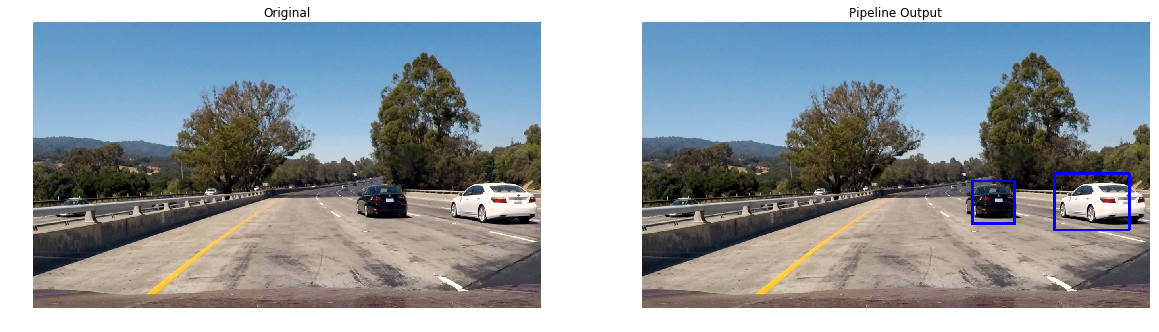

In [11]:
import time

testImage_DIR = './11-input-testImages/'
img = mpimg.imread(testImage_DIR + 'test1.jpg')

init_pipeline()
start_time = time.time()
out = pipeline(img, plot=False)
print("Pipeline process time: %s seconds " % (time.time() - start_time))

pltCompare(img, 'Original', out, 'Pipeline Output')

Pipeline processing: test3.jpg ...


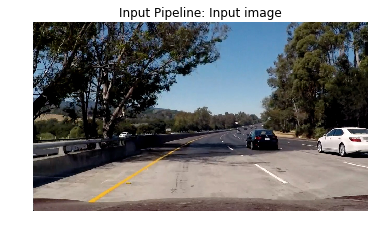

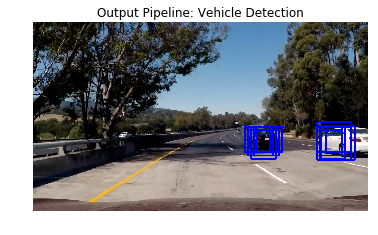

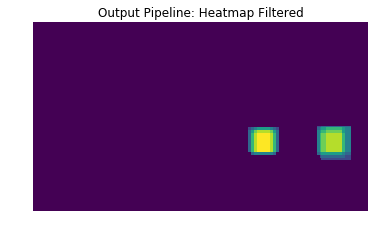

Pipeline done!
Final result:


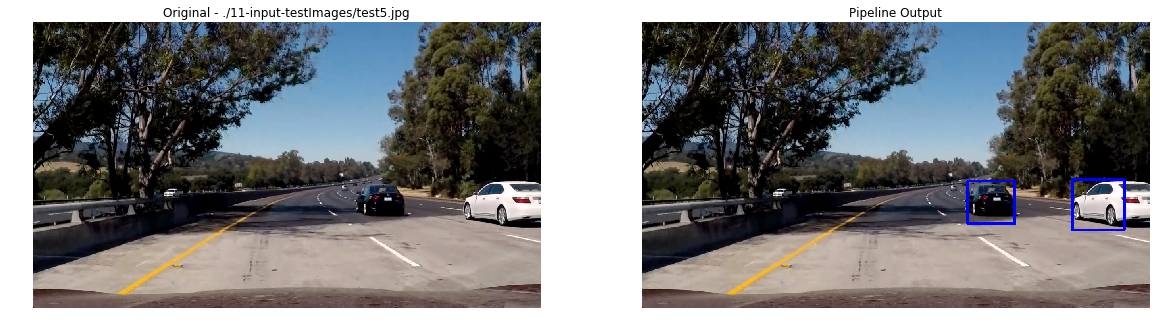

*********************
*********************
*********************

Pipeline processing: test5.jpg ...


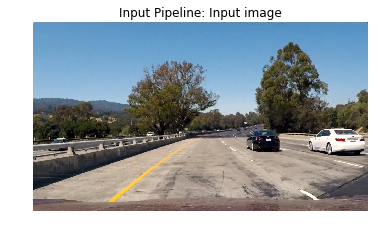

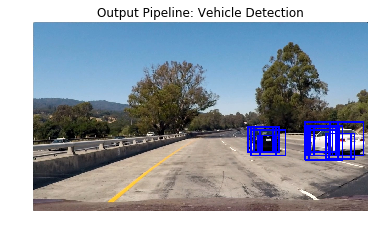

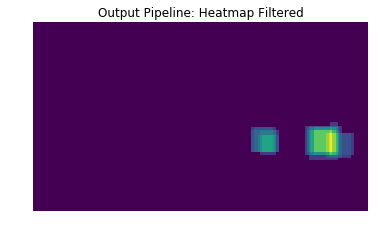

Pipeline done!
Final result:


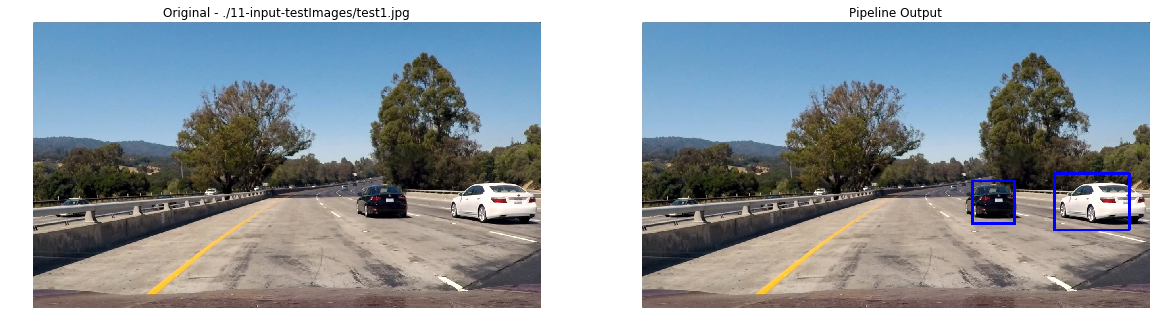

*********************
*********************
*********************

Pipeline processing: test1.jpg ...


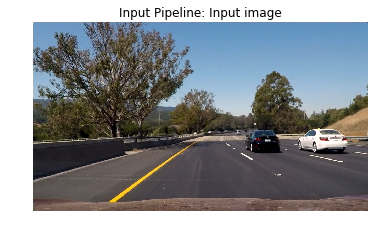

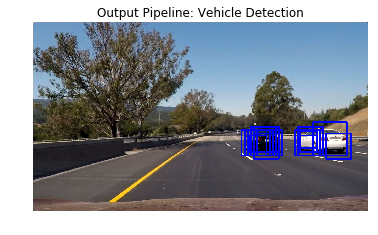

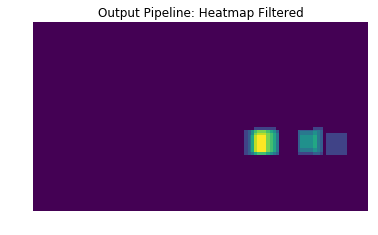

Pipeline done!
Final result:


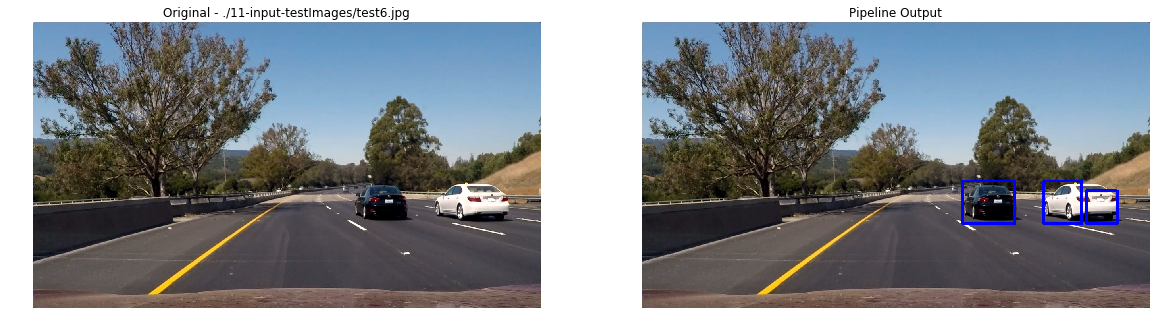

*********************
*********************
*********************

Pipeline processing: test6.jpg ...


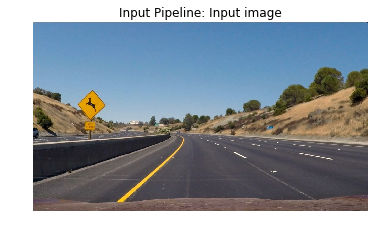

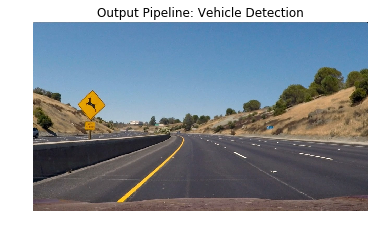

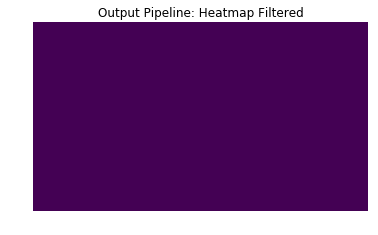

Pipeline done!
Final result:


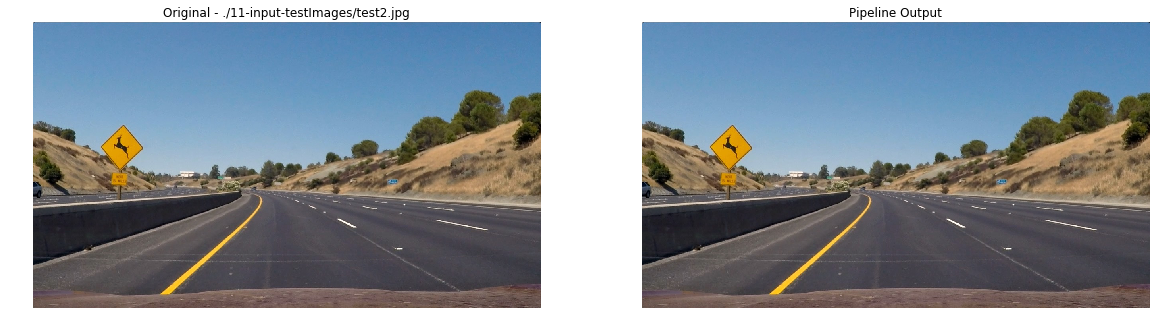

*********************
*********************
*********************

Pipeline processing: test2.jpg ...


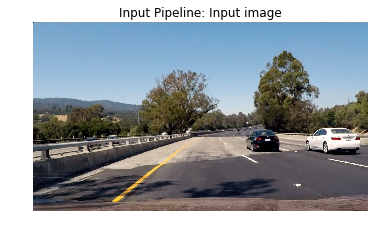

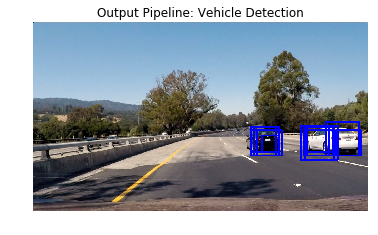

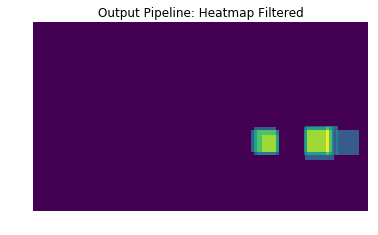

Pipeline done!
Final result:


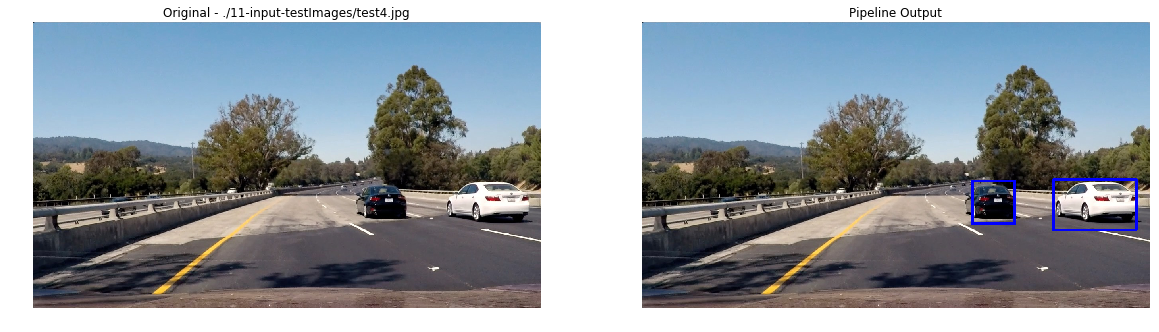

*********************
*********************
*********************

Pipeline processing: test4.jpg ...


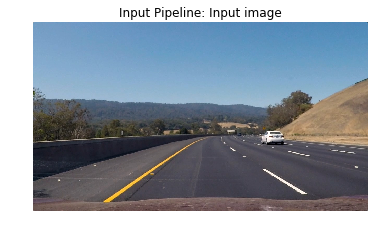

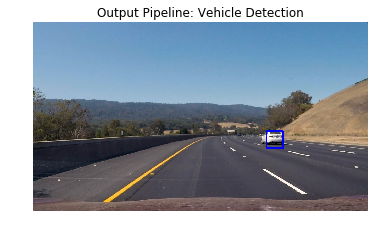

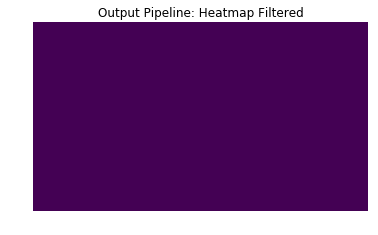

Pipeline done!
Final result:


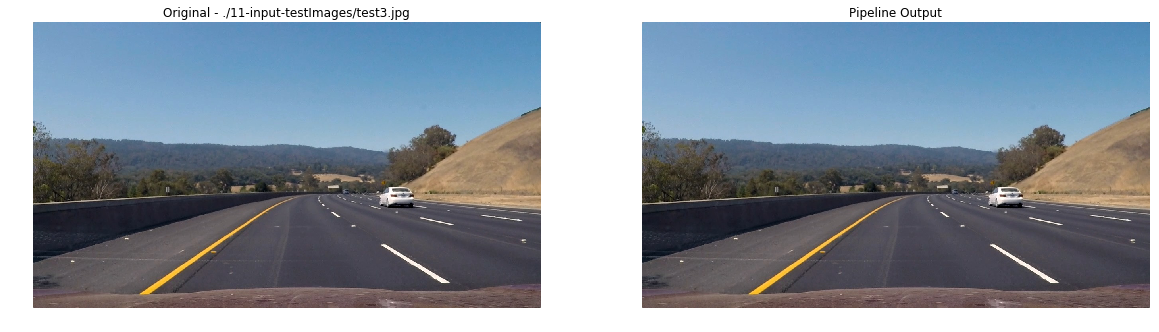

*********************
*********************
*********************



In [16]:
import glob
import os
testImage_DIR = './11-input-testImages/'
images = glob.glob(testImage_DIR + '*.jpg')

for fname in images:
    img = mpimg.imread(fname)
    print('Pipeline processing: {} ...'.format(file))
    init_pipeline()
    out = pipeline(img, plot=True)
    file = os.path.basename(fname)
    print('Pipeline done!')
    print('Final result:'.format(file))
    pltCompare(img, 'Original - {}'.format(fname), out, 'Pipeline Output')
    print('*********************')
    print('*********************')
    print('*********************')
    print()

> **HMA**: Note the pipeline processing output from test3.jpg. This specific pipeline presents the vehicle detection by one window, which is not enough so the false positive filter eliminates it. A the video feed, the Momentum from previous detections still would allow the detection, but after some time it would no longer detect the vehicle. This is the expected behavior from the design (choice of window scales, sliding window region and associated steps) for this pipeline. 

## Pipeline Visualization - Video
As required by the project, the pipeline was used to process an image stream and reconstruct the output into a video. 

In [17]:
def process_image(image):
    return pipeline(image, plot=False)

In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

init_pipeline(25)
video_output = '20-output-projectVideo.mp4'
clip = VideoFileClip('./10-input-videos/10-input-projectVideo.mp4')
video_output_clip = clip.fl_image(process_image)
%time video_output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video 20-output-projectVideo.mp4
[MoviePy] Writing video 20-output-projectVideo.mp4


100%|█████████▉| 1260/1261 [10:49<00:00,  1.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: 20-output-projectVideo.mp4 

CPU times: user 10min 47s, sys: 2.32 s, total: 10min 49s
Wall time: 10min 50s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Conclusion and discussion

The developed pipeline contains parts of source code provided by Udacity. Nevertheless, using them required some integration code, code modifications and deep analysis in order to form an image processing pipeline. It was not a trivial project.

The following points explore different aspects from this project.

- Difficulties 
  - Get the pipeline working with the Classifier Model output, features and sizes synced to the Training, heat map history, false positives removal and window stabilization was hard, despite the given code samples and videos from the lesson. 
  - The window stabilization works, but getting it to the pipeline was not simple.
  - Sync the features extraction from the training phase to the pipeline feature extraction. A mixture of experimentation for the Model training while already building the pipeline led to some bugs.

- Positive aspects
  - The pipeline detects the vehicles with a good accuracy. It does not detects the white vehicle for some period, but this was expected due to the tunned parameter of window sizes, sliding steps and regions of interest. They were optimizes to provide a faster image pipeline.
  - The heat map implementation helps to unify overlapping windows and to remove false positives.
  - Despite being a long, this is a explanatory pipeline, for the required steps, rather then a production oriented pipeline. It presents well each step for the vehicle detection, tracking but also the pipeline partial image outputs.

- Possible improvements 
  - Several improvements would be required for a real time image processing. The current pipeline "do the job" for this project, but it still is timely ineficiente. At the current configuration (i5 dual core), the attained rate was processing around 2 frames per second.
  - The current pipeline perform the sliding window throughout the entire search region for a given window size.A possible improvement is the use from the previous heatmap region to reduce the region of interes and consequently speed the tracking.
  - The current pipeline also only searches for a small area at the right side lanes from the vehicle, inferring a special region of interest specifically for this video input, coming for instance from a radar sensor. This improvement at image processing speed comes at the cost that the pipeline do not detect cars in front or at the left side lane of the vehicle. A pipeline throughout the entire horizon could serve as a redundancy from this hypothetical radar sensor.
  - The classifier could also be more robust, the detection is fine but not optimal. There is room for improvement at the model training, such as training parameters and used datasets. There are a few possiblities, from parameter tunning for the training, to the use of larger such as Udacity's newer datasets.